In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import pdb
from tqdm import tqdm

import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import pairwise_distances
import jellyfish

import joblib
from joblib import Parallel, delayed

np.random.seed(97)

In [2]:
final_design_seqs_dir = "/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/writeup"
ensemble_predictions_dir = "/global/scratch/users/aniketh/promoter_modelling/jax_data/ensemble_predictions/"

In [3]:
# NOTE: ensemble 0 is the original ensemble 3 and ensemble 1 is the original ensemble 4
ensemble_1_filtered_sequences = pd.read_parquet(os.path.join(ensemble_predictions_dir, 
                                                             "filtered_ensemble_4_predictions.parquet"))
ensemble_1_dataset_seqs = ensemble_1_filtered_sequences[ensemble_1_filtered_sequences["design_method"] == "Dataset"].reset_index(drop=True)

In [ ]:
methods = ["coms_final_design_v2", 
           "dens_final_design_v2_diversity_0.0", 
           "dens_final_design_v2_diversity_0.1",
           "dens_final_design_v2_diversity_0.3",
           "dens_final_design_v2_diversity_1.0",
           "dens_final_design_v2_diversity_3.0",
           "dens_final_design_v2_diversity_10.0", 
           "gradient_ascent_final_design_v2"]

method_to_name = {"coms_final_design_v2": "COMs", 
               "dens_final_design_v2_diversity_0.0": r"DENs with $\beta = 0.0$", 
               "dens_final_design_v2_diversity_0.1": r"DENs with $\beta = 0.1$",
               "dens_final_design_v2_diversity_0.3": r"DENs with $\beta = 0.3$",
               "dens_final_design_v2_diversity_1.0": r"DENs with $\beta = 1.0$",
               "dens_final_design_v2_diversity_3.0": r"DENs with $\beta = 3.0$",
               "dens_final_design_v2_diversity_10.0": r"DENs with $\beta = 10.0$", 
               "gradient_ascent_final_design_v2": "Gradient Ascent"}

name_map = {"jurkat": "Jurkat", "k562": "K562", "thp1": "THP1"}
    
for i, method in enumerate(methods):
    print(method)
    seqs = pickle.load(open(os.path.join(final_design_seqs_dir, f"{method}.pkl"), "rb"))
    seqs_df = []
    kmer_features = {}
    for cell in ["jurkat", "k562", "thp1"]:
        kmer_features[cell] = seqs[cell]["kmer_features"]
        seqs[cell].pop("kmer_features")
        df = pd.DataFrame(seqs[cell])
        df["designed_for"] = cell
        
        seqs_df.append(df)
    
    seqs_df = pd.concat(seqs_df).reset_index(drop=True)
    sequences = list(seqs_df["sequences"])
    
    if not os.path.exists(os.path.join(final_design_seqs_dir, f"{method}_pairwise_damerau_levenshtein_distances.npy")):
        pairwise_edit_distances = Parallel(n_jobs=-1)(delayed(jellyfish.damerau_levenshtein_distance)(sequences[i], sequences[j]) 
                                                      for i in tqdm(range(len(sequences))) 
                                                      for j in range(i+1, len(sequences), 1))
        np.save(os.path.join(final_design_seqs_dir, f"{method}_pairwise_damerau_levenshtein_distances.npy"), pairwise_edit_distances)

coms_final_design_v2


100%|██████████| 15000/15000 [2:28:55<00:00,  1.68it/s] 


dens_final_design_v2_diversity_0.0


 21%|██        | 2934/14256 [52:36<3:05:07,  1.02it/s]

In [6]:
pairwise_edit_distances = np.load(os.path.join(final_design_seqs_dir, f"pairwise_damerau_levenshtein_distances_writeup.npy"))

In [7]:
pairwise_distances = np.zeros((len(raw_seqs), len(raw_seqs)))
triu_inds = np.triu_indices_from(pairwise_distances, k=1)
pairwise_distances[triu_inds] = pairwise_edit_distances
pairwise_distances = pairwise_distances + pairwise_distances.T # copy elements from triu to tril
# c = 0
# for i in tqdm(range(len(raw_seqs))):
#     for j in range(i+1, len(raw_seqs), 1):
#         pairwise_distances[i][j] = pairwise_edit_distances[c]
#         pairwise_distances[j][i] = pairwise_edit_distances[c]
#         c += 1

In [8]:
pairwise_distances

array([[  0., 139., 131., ..., 162., 156., 163.],
       [139.,   0., 122., ..., 135., 130., 133.],
       [131., 122.,   0., ..., 134., 130., 132.],
       ...,
       [162., 135., 134., ...,   0.,  36.,  31.],
       [156., 130., 130., ...,  36.,   0.,  32.],
       [163., 133., 132., ...,  31.,  32.,   0.]])

(12000, 12000)
(12000,)


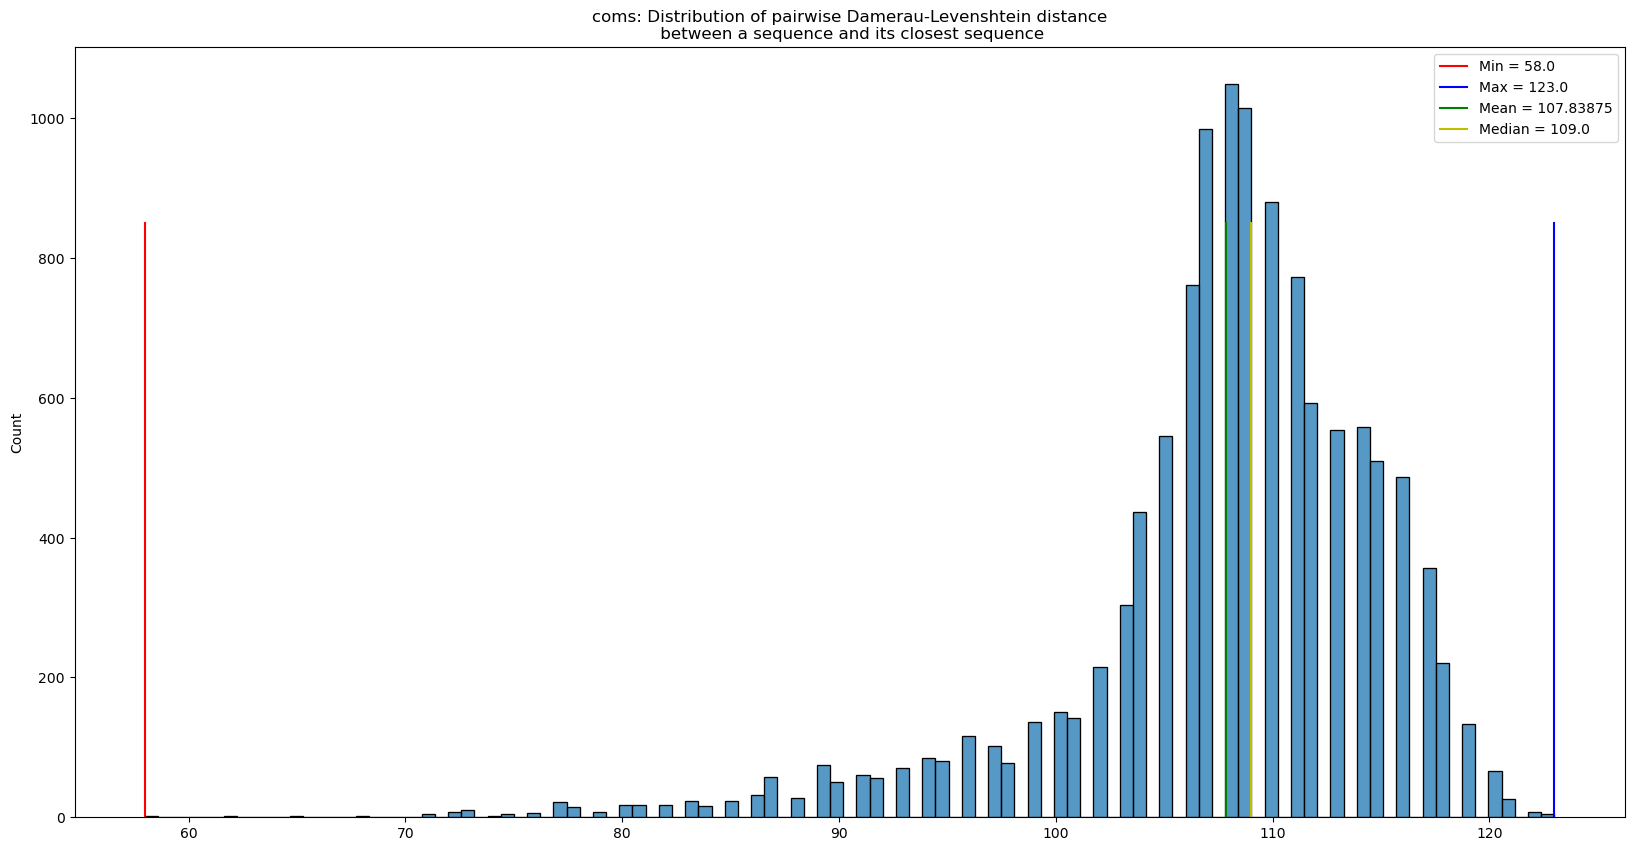

(3000, 3000)
(3000,)


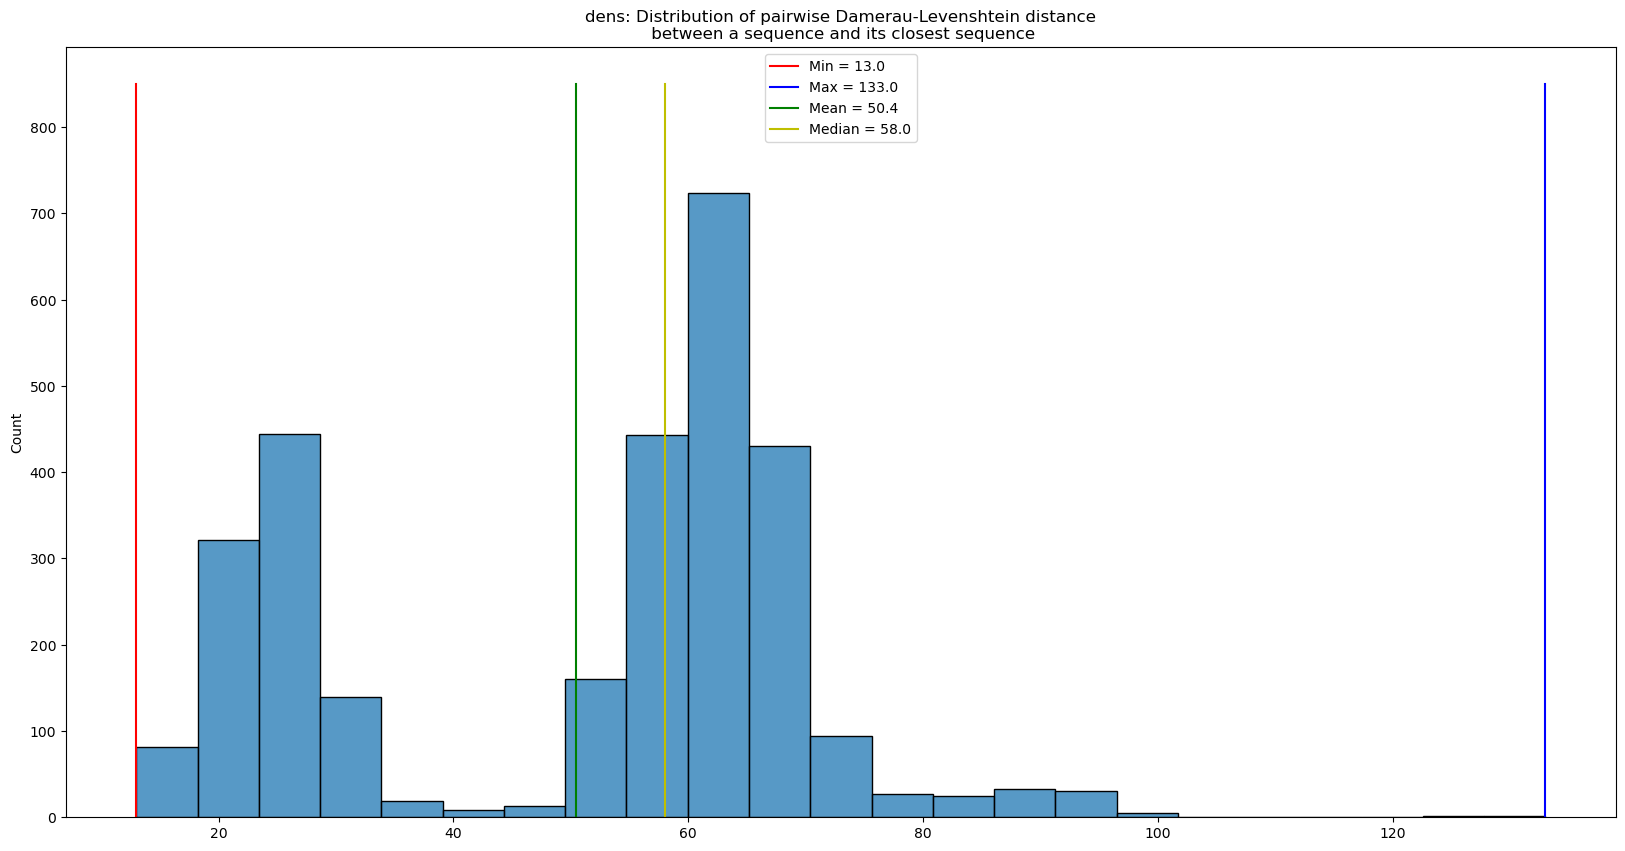

(17104, 17104)
(17104,)


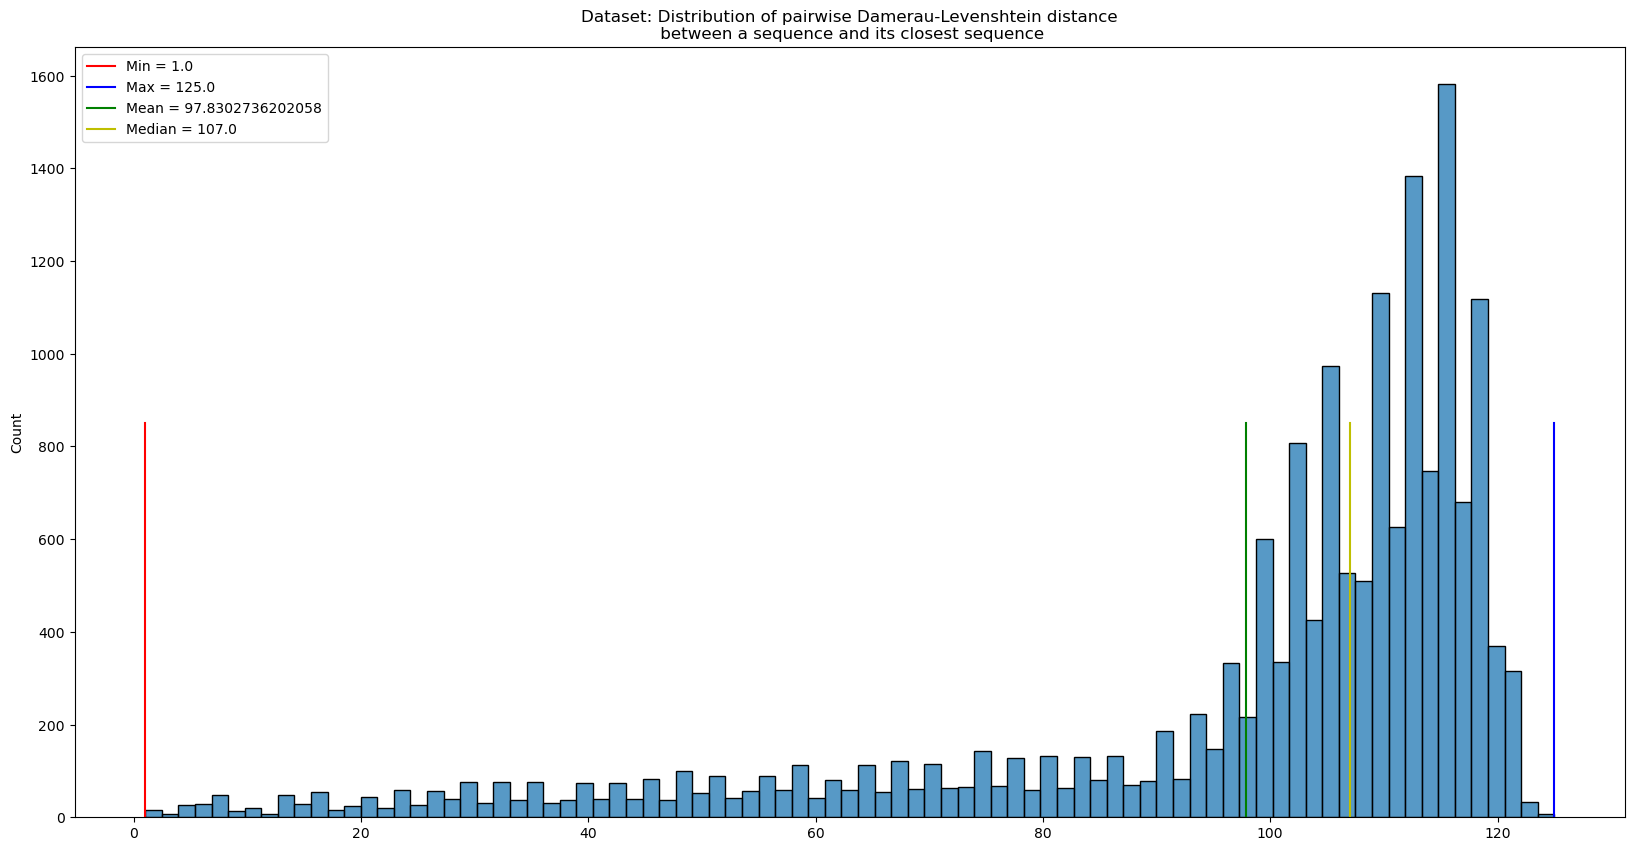

(29206, 29206)
(29206,)


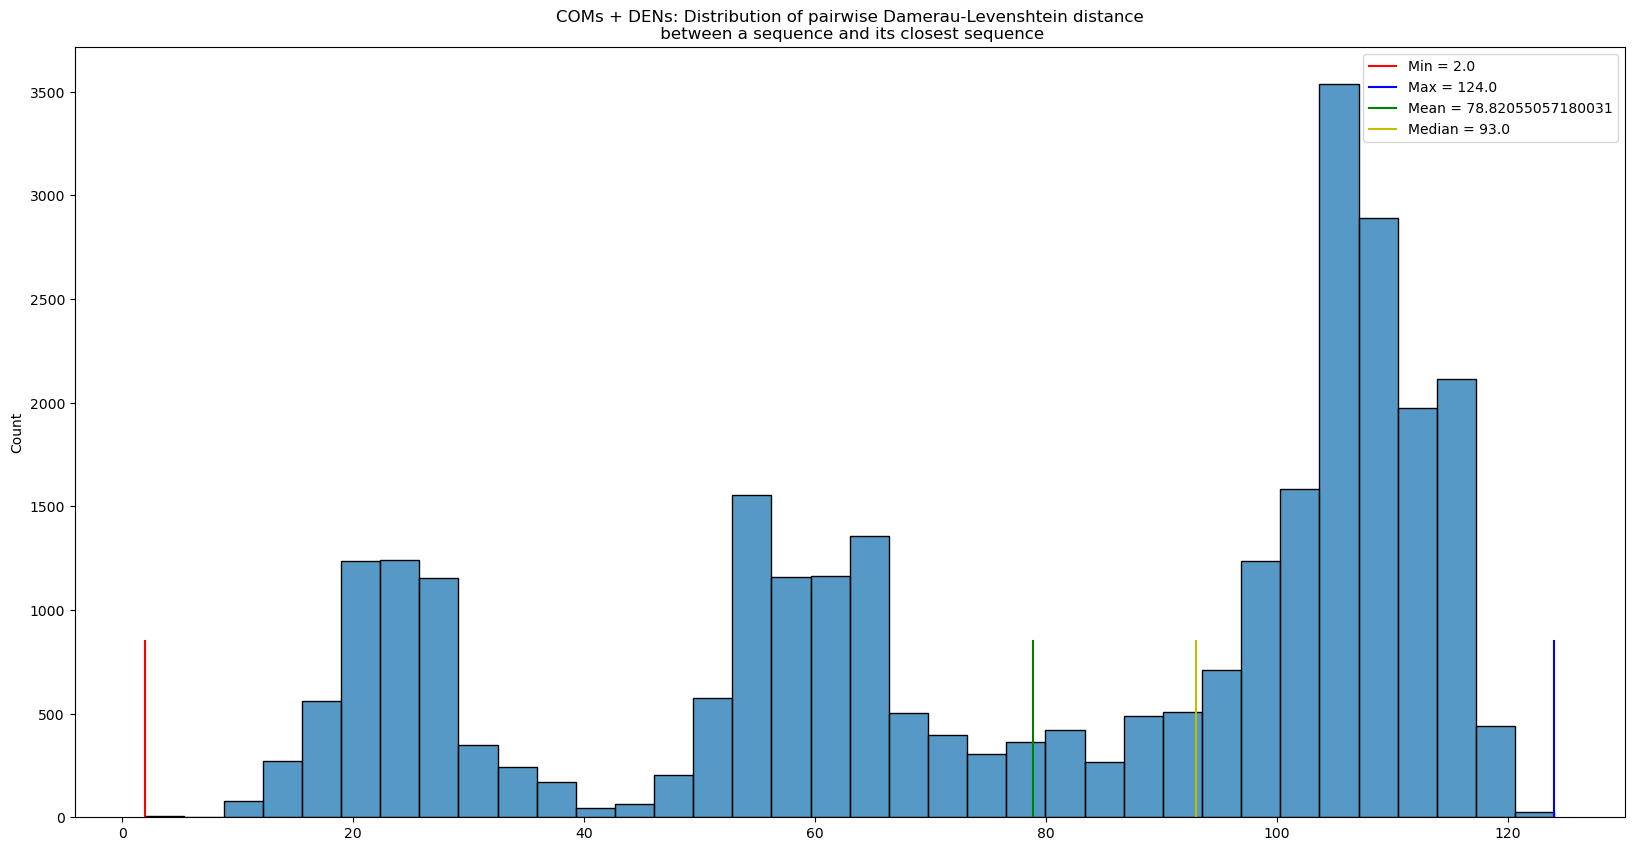

In [9]:
# get distribution of min pairwise distances for each method
for method in methods + ["Dataset", "COMs + DENs"]:
    if method == "COMs + DENs":
        seq_inds = all_sources != "Dataset"
    else:
        seq_inds = all_sources == method
    method_pairwise_dist_matrix = pairwise_distances[seq_inds][:, seq_inds]
    print(method_pairwise_dist_matrix.shape)
    diag_inds = np.diag_indices_from(method_pairwise_dist_matrix)
    method_pairwise_dist_matrix[diag_inds] = np.inf
    min_dist_to_another_seq = method_pairwise_dist_matrix.min(axis=1)
    print(min_dist_to_another_seq.shape)
    
#     triu_inds = np.triu_indices_from(method_pairwise_dist_matrix, k=-1)
#     triu_mat = method_pairwise_dist_matrix[triu_inds]
    
    plt.figure(figsize=(20, 10))
    sns.histplot(min_dist_to_another_seq)
    plt.plot([min_dist_to_another_seq.min() for i in range(10)], np.linspace(0, 850, 10), "r-", label=f"Min = {min_dist_to_another_seq.min()}")
    plt.plot([min_dist_to_another_seq.max() for i in range(10)], np.linspace(0, 850, 10), "b-", label=f"Max = {min_dist_to_another_seq.max()}")
    plt.plot([min_dist_to_another_seq.mean() for i in range(10)], np.linspace(0, 850, 10), "g-", label=f"Mean = {min_dist_to_another_seq.mean()}")
    plt.plot([np.median(min_dist_to_another_seq) for i in range(10)], np.linspace(0, 850, 10), "y-", label=f"Median = {np.median(min_dist_to_another_seq)}")
    plt.title(f"{method}: Distribution of pairwise Damerau-Levenshtein distance\n between a sequence and its closest sequence")
    plt.legend()
    plt.show()

(12000,)


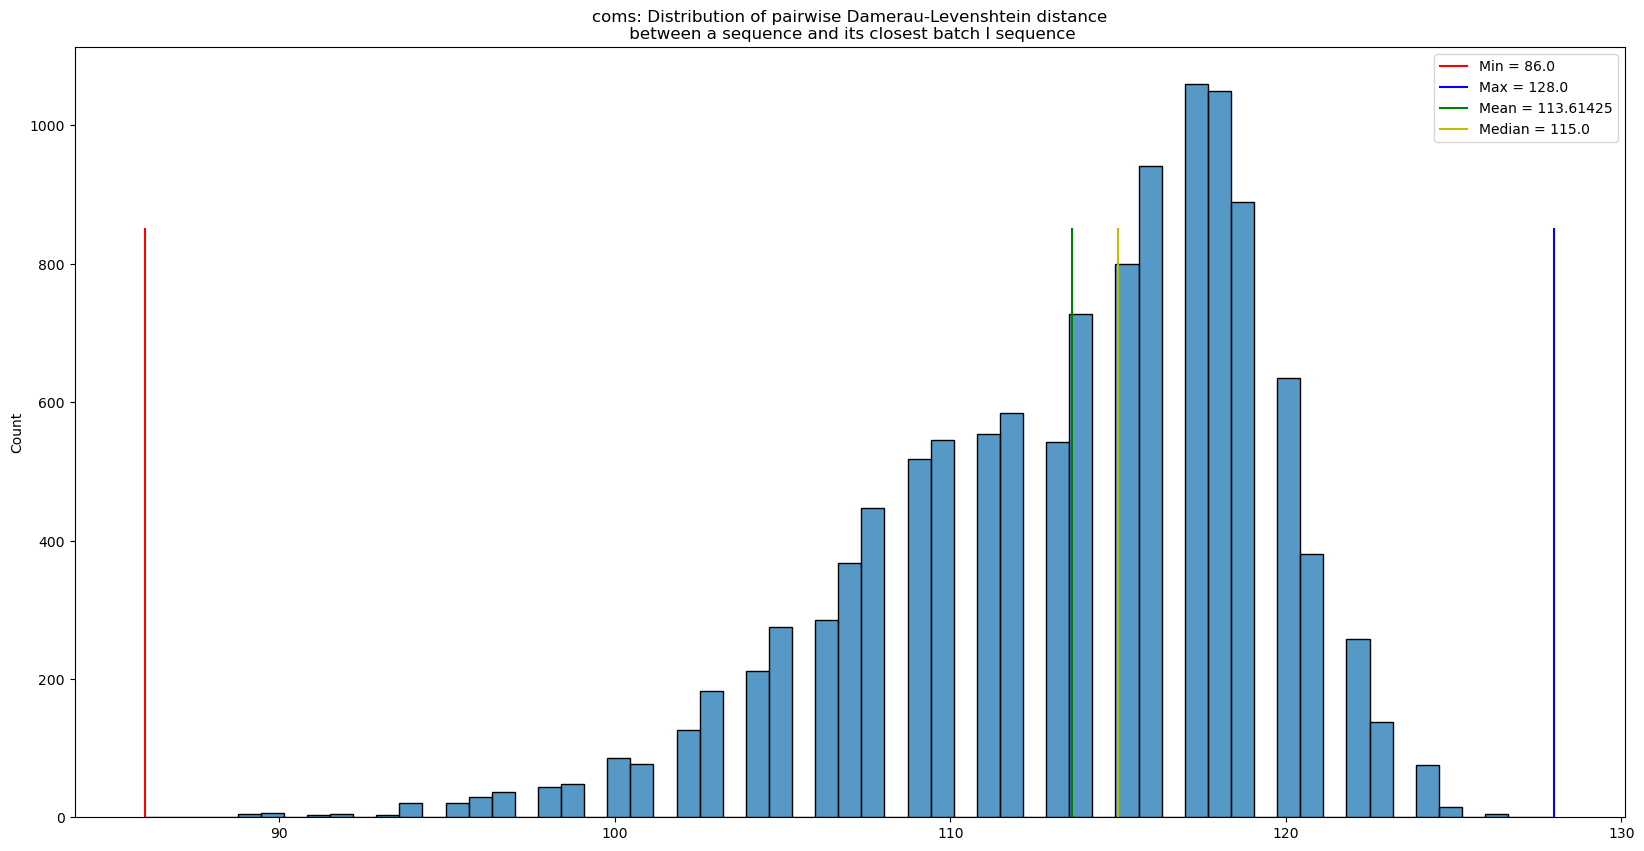

(3000,)


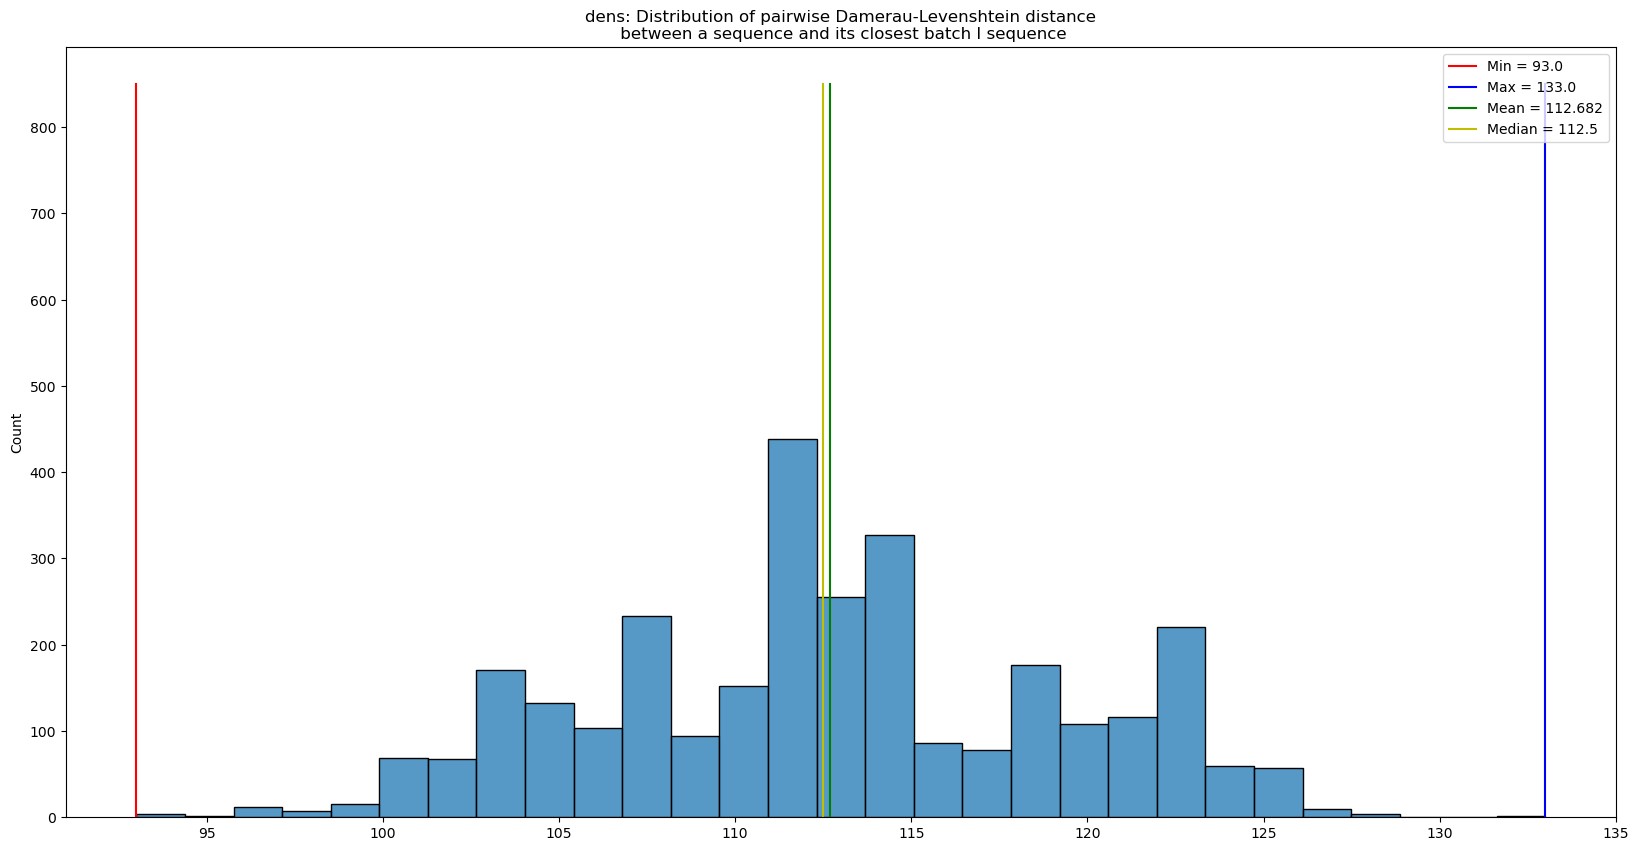

(29206,)


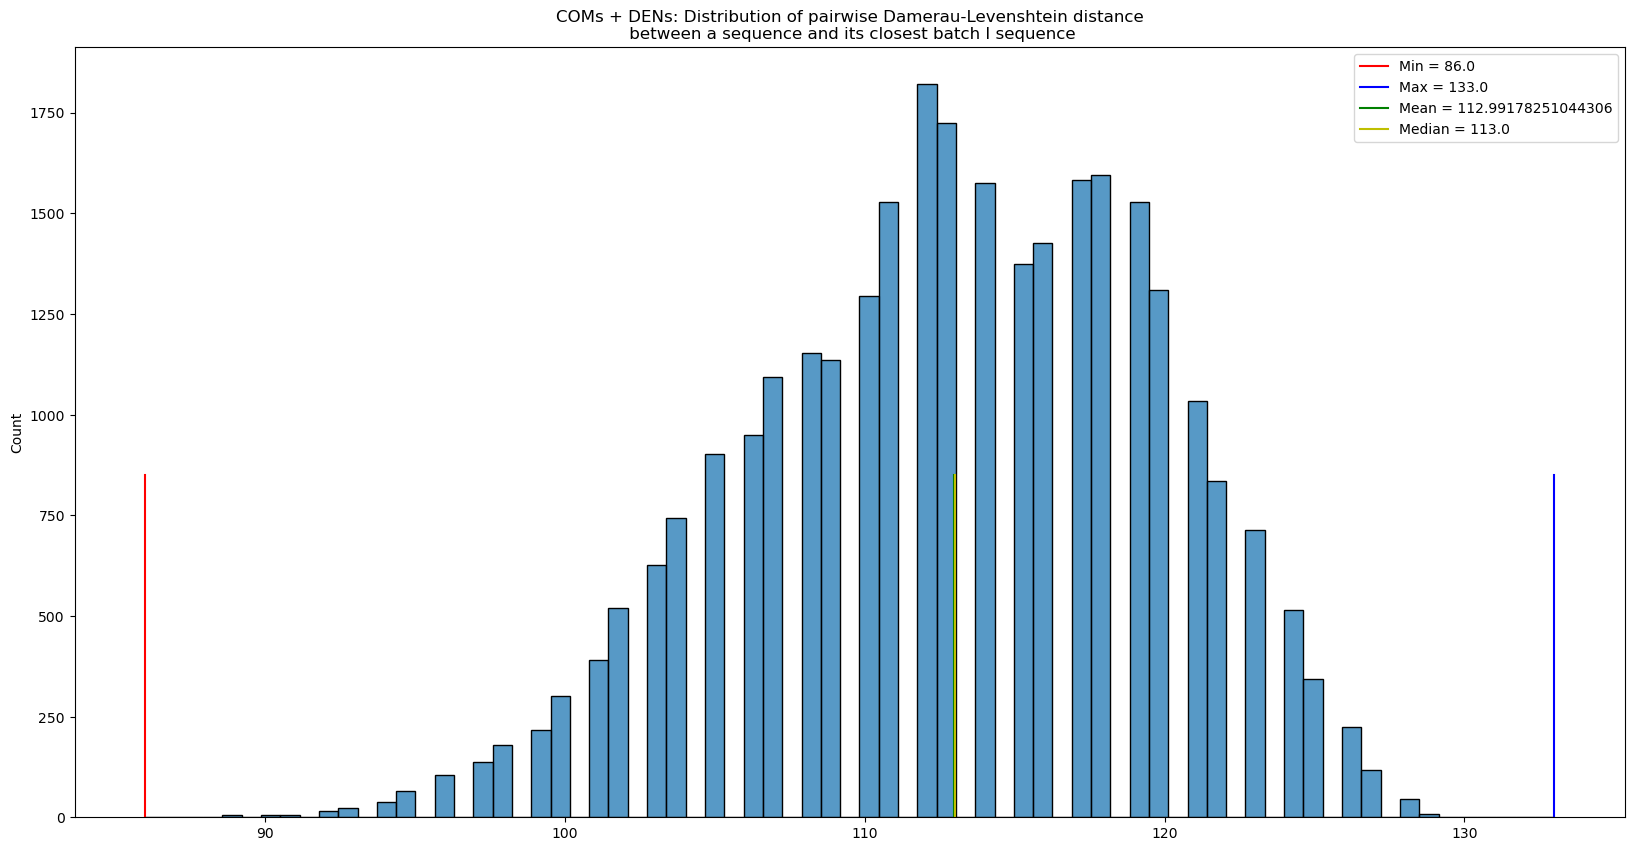

In [10]:
# get distribution of min pairwise distances for each method to batch I sequences
for method in methods + ["COMs + DENs"]:
    if method == "COMs + DENs":
        seq_inds = all_sources != "Dataset"
    else:
        seq_inds = all_sources == method
    dataset_seq_inds = all_sources == "Dataset"
    method_pairwise_dist_matrix = pairwise_distances[seq_inds][:, dataset_seq_inds]
    min_dist_to_another_seq = method_pairwise_dist_matrix.min(axis=1)
    print(min_dist_to_another_seq.shape)
    
#     triu_inds = np.triu_indices_from(method_pairwise_dist_matrix, k=-1)
#     triu_mat = method_pairwise_dist_matrix[triu_inds]
    
    plt.figure(figsize=(20, 10))
    sns.histplot(min_dist_to_another_seq)
    plt.plot([min_dist_to_another_seq.min() for i in range(10)], np.linspace(0, 850, 10), "r-", label=f"Min = {min_dist_to_another_seq.min()}")
    plt.plot([min_dist_to_another_seq.max() for i in range(10)], np.linspace(0, 850, 10), "b-", label=f"Max = {min_dist_to_another_seq.max()}")
    plt.plot([min_dist_to_another_seq.mean() for i in range(10)], np.linspace(0, 850, 10), "g-", label=f"Mean = {min_dist_to_another_seq.mean()}")
    plt.plot([np.median(min_dist_to_another_seq) for i in range(10)], np.linspace(0, 850, 10), "y-", label=f"Median = {np.median(min_dist_to_another_seq)}")
    plt.title(f"{method}: Distribution of pairwise Damerau-Levenshtein distance\n between a sequence and its closest batch I sequence")
    plt.legend()
    plt.show()

(12000, 12000)
(12000,)


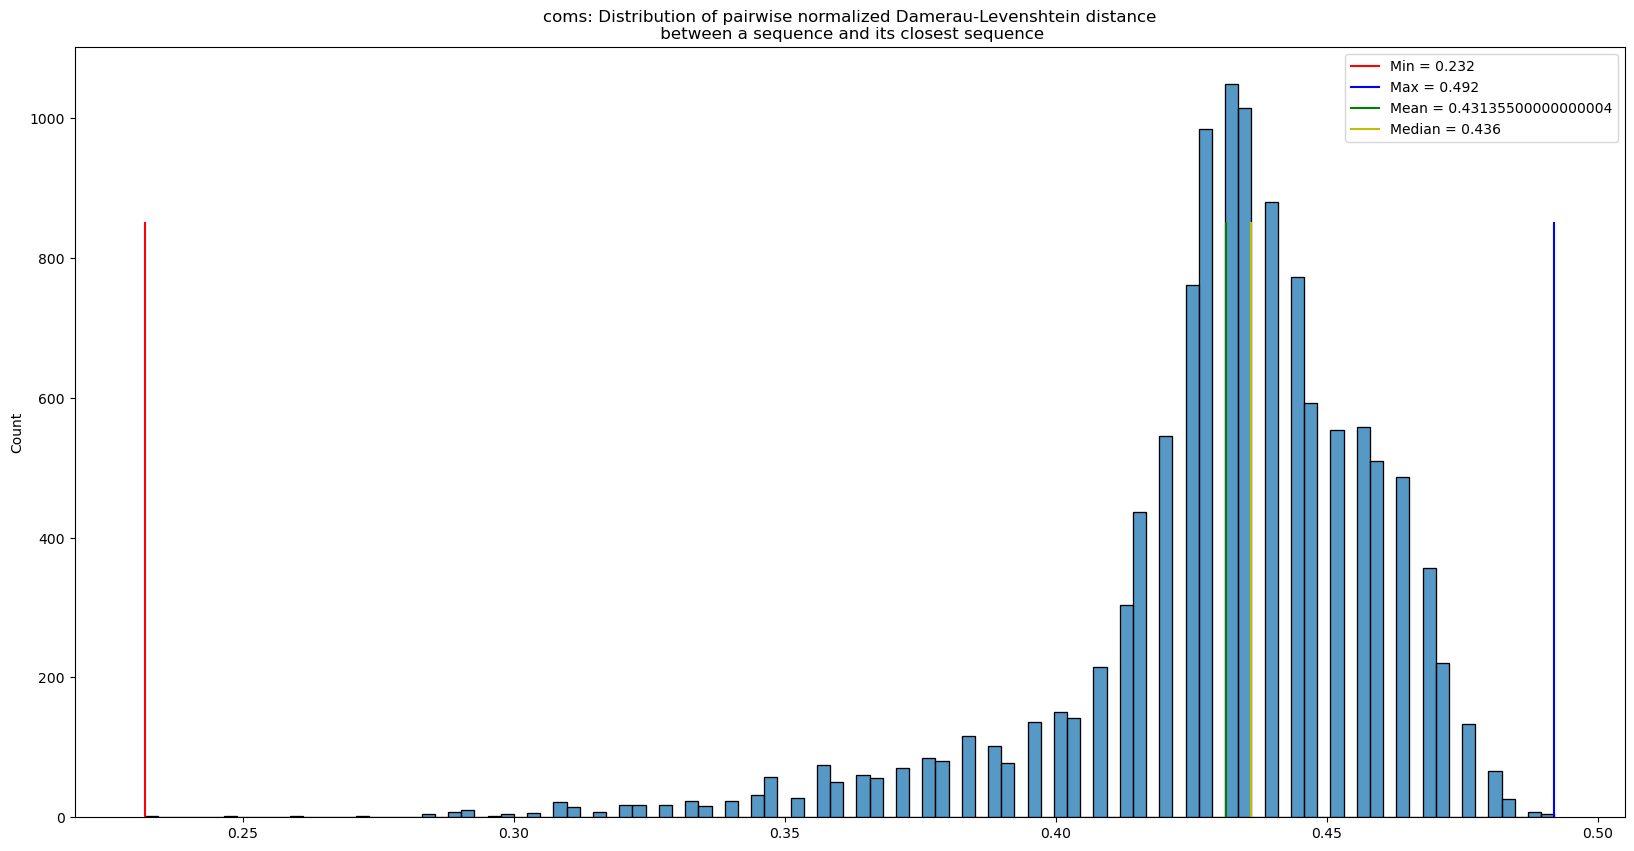

(3000, 3000)
(3000,)


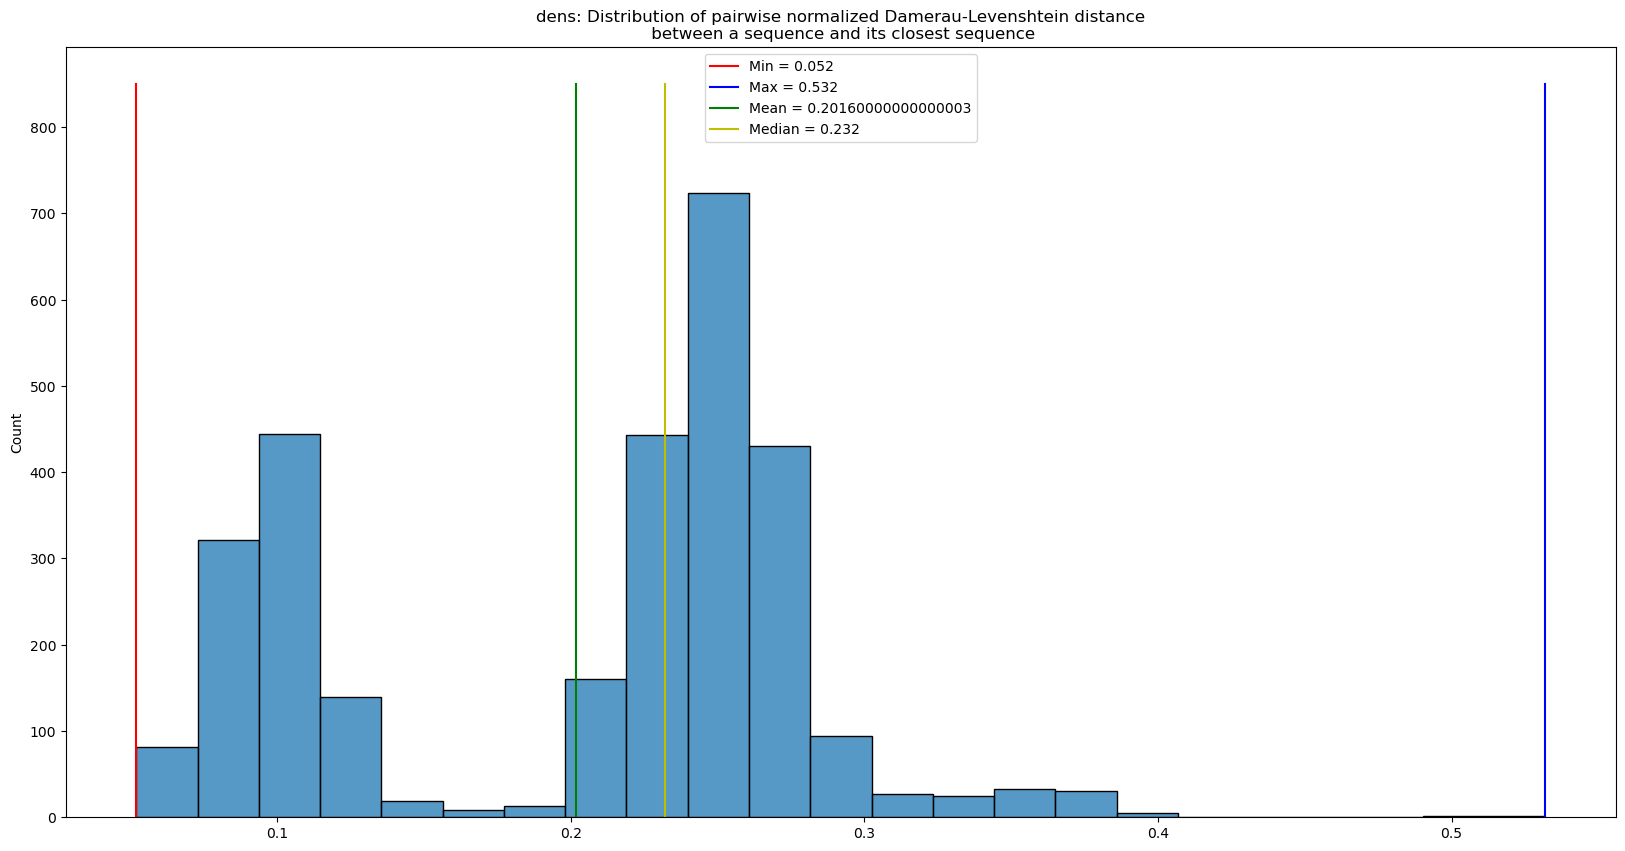

(17104, 17104)
(17104,)


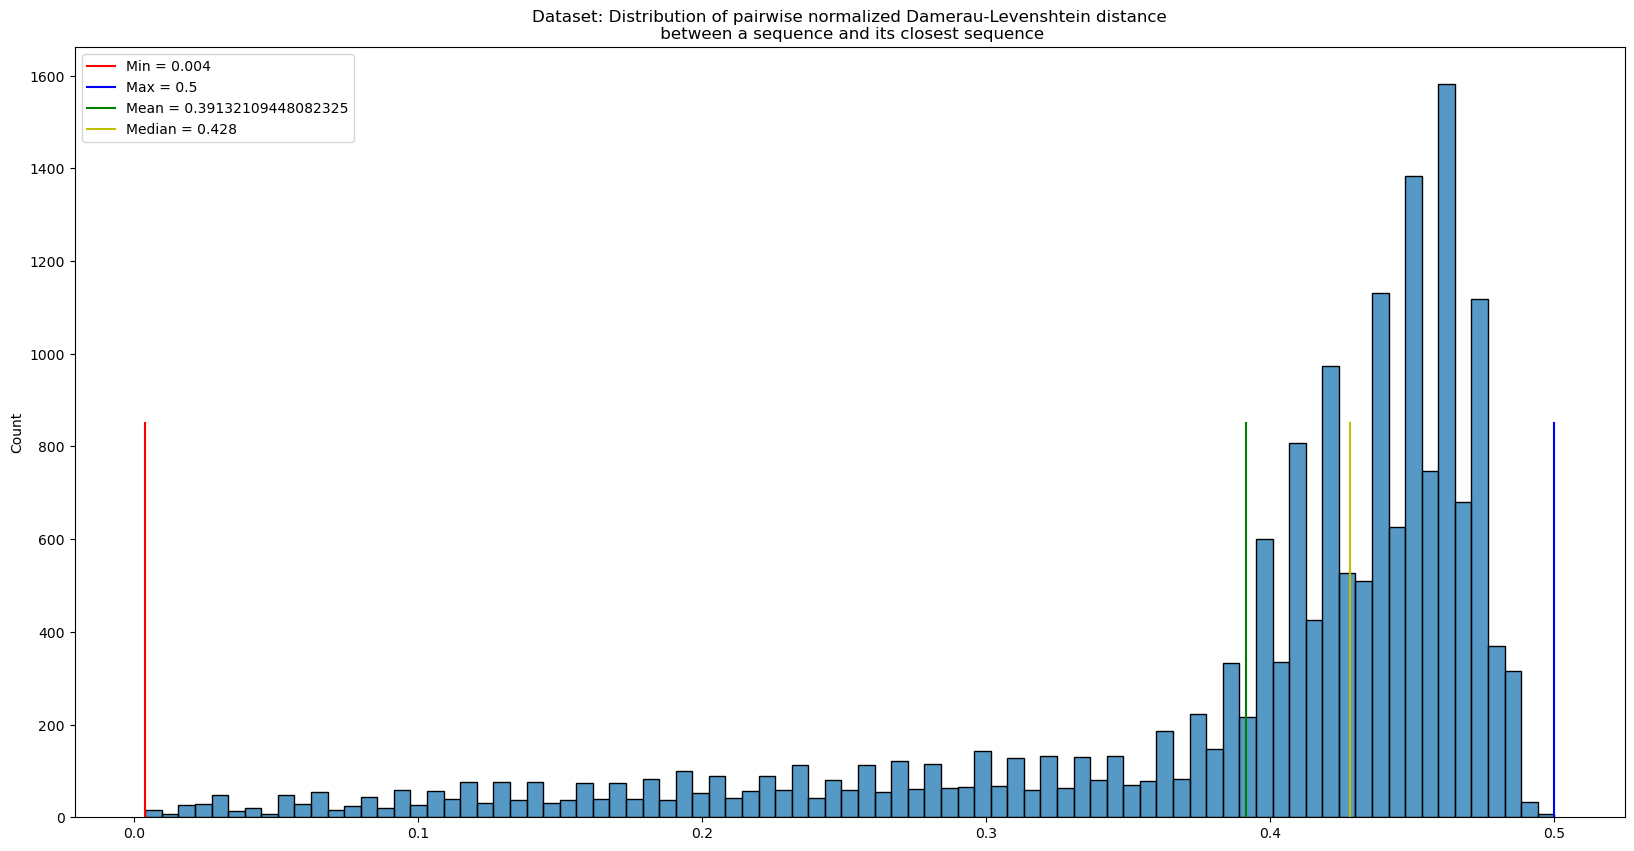

(29206, 29206)
(29206,)


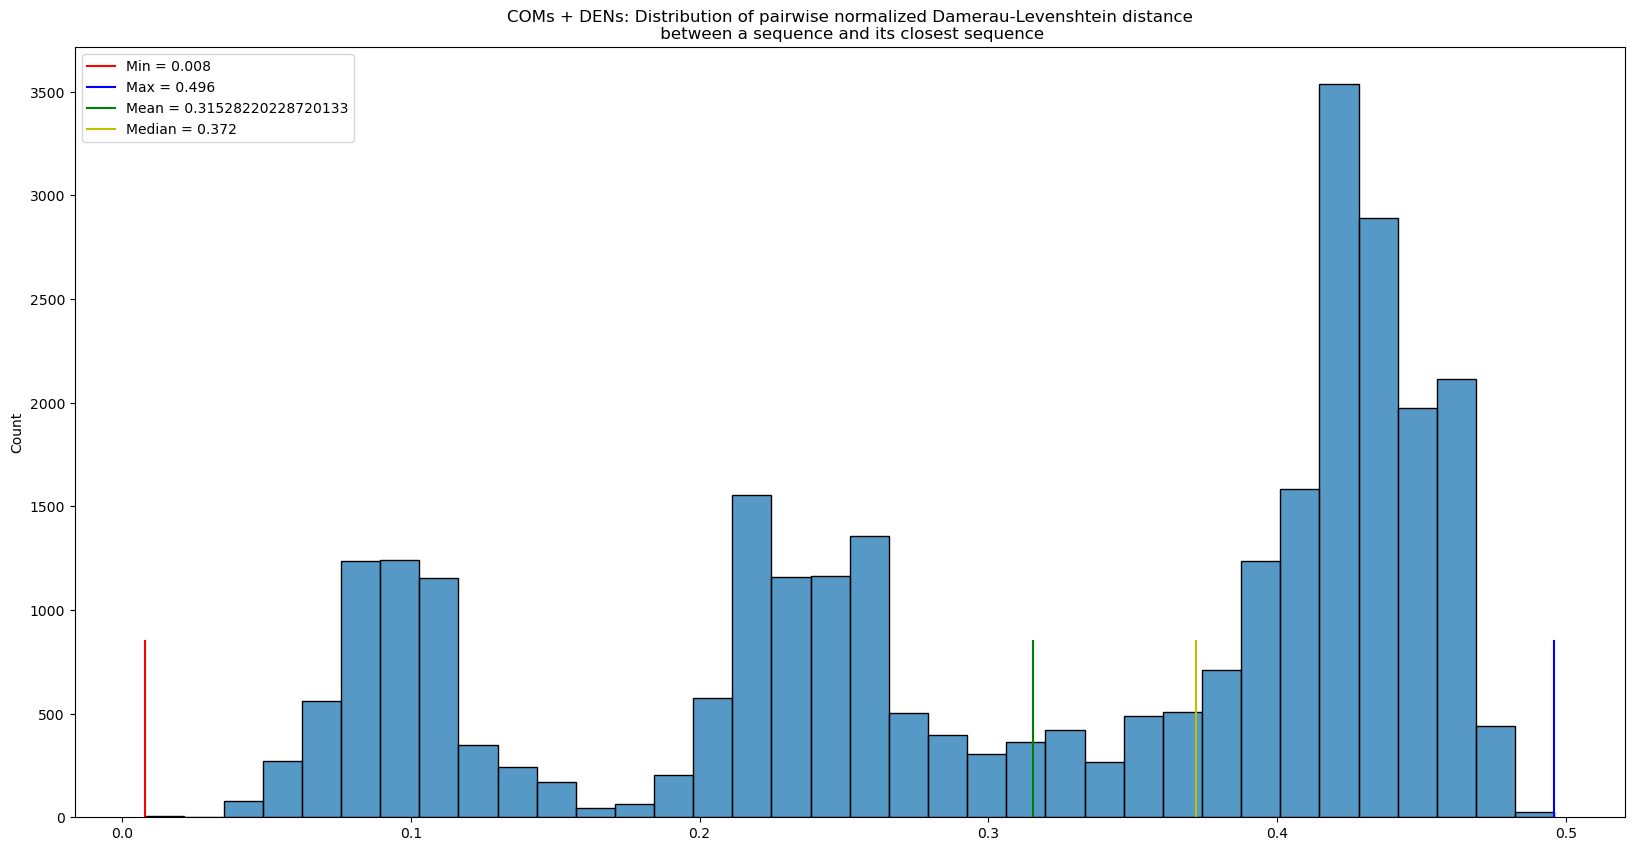

In [11]:
# get distribution of min pairwise distances for each method
for method in methods + ["Dataset", "COMs + DENs"]:
    if method == "COMs + DENs":
        seq_inds = all_sources != "Dataset"
    else:
        seq_inds = all_sources == method
    method_pairwise_dist_matrix = pairwise_distances[seq_inds][:, seq_inds]
    print(method_pairwise_dist_matrix.shape)
    diag_inds = np.diag_indices_from(method_pairwise_dist_matrix)
    method_pairwise_dist_matrix[diag_inds] = np.inf
    min_dist_to_another_seq = method_pairwise_dist_matrix.min(axis=1) / 250
    print(min_dist_to_another_seq.shape)
    
#     triu_inds = np.triu_indices_from(method_pairwise_dist_matrix, k=-1)
#     triu_mat = method_pairwise_dist_matrix[triu_inds]
    
    plt.figure(figsize=(20, 10))
    sns.histplot(min_dist_to_another_seq)
    plt.plot([min_dist_to_another_seq.min() for i in range(10)], np.linspace(0, 850, 10), "r-", label=f"Min = {min_dist_to_another_seq.min()}")
    plt.plot([min_dist_to_another_seq.max() for i in range(10)], np.linspace(0, 850, 10), "b-", label=f"Max = {min_dist_to_another_seq.max()}")
    plt.plot([min_dist_to_another_seq.mean() for i in range(10)], np.linspace(0, 850, 10), "g-", label=f"Mean = {min_dist_to_another_seq.mean()}")
    plt.plot([np.median(min_dist_to_another_seq) for i in range(10)], np.linspace(0, 850, 10), "y-", label=f"Median = {np.median(min_dist_to_another_seq)}")
    plt.title(f"{method}: Distribution of pairwise normalized Damerau-Levenshtein distance\n between a sequence and its closest sequence")
    plt.legend()
    plt.show()

(12000,)


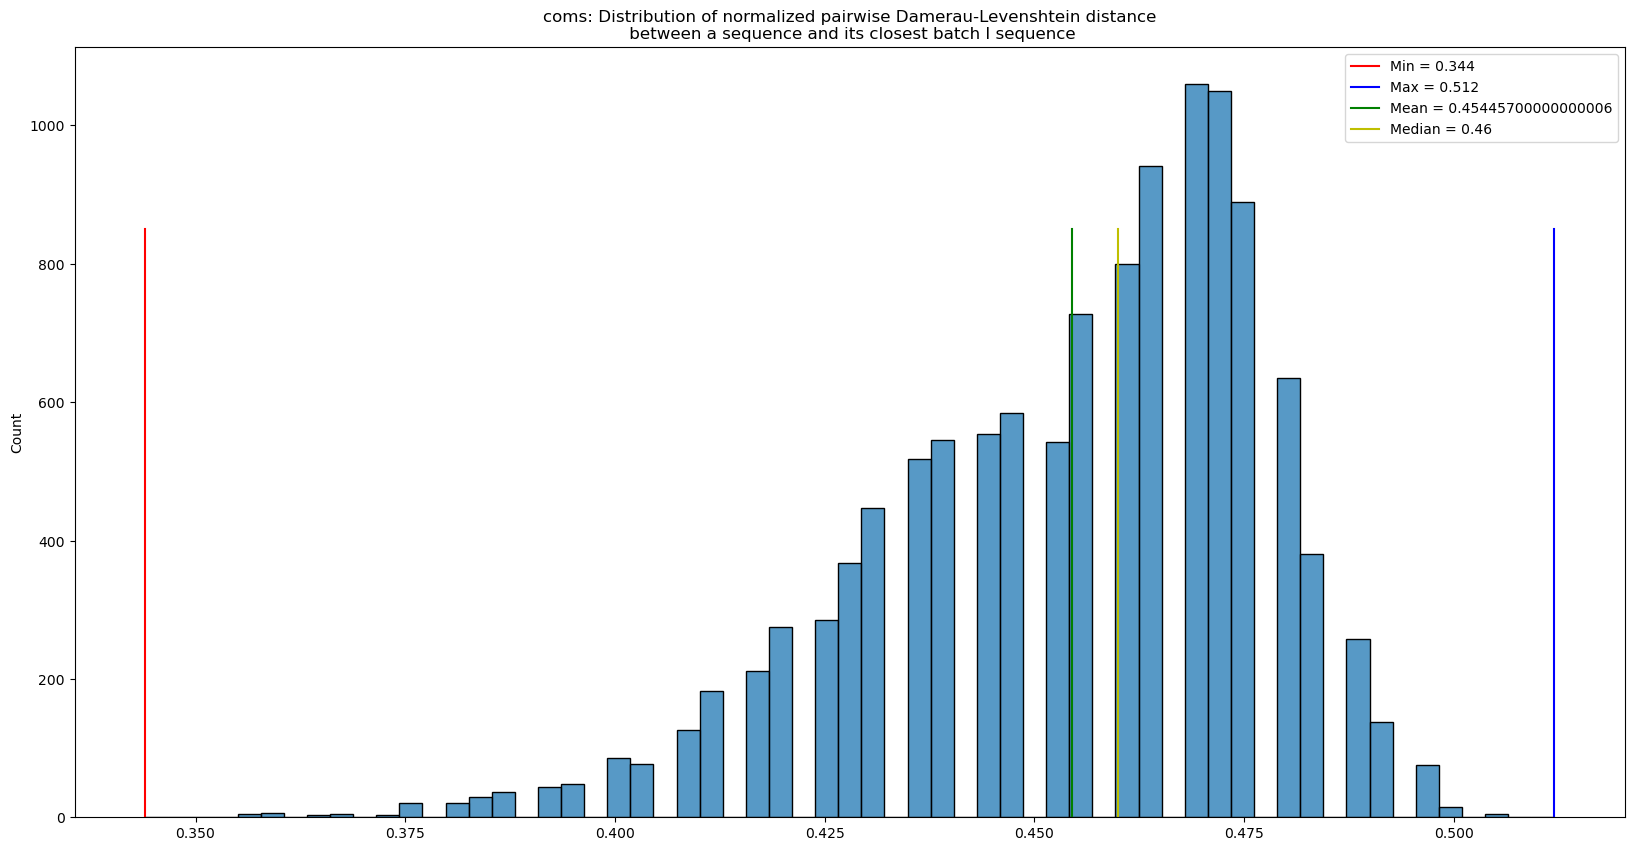

(3000,)


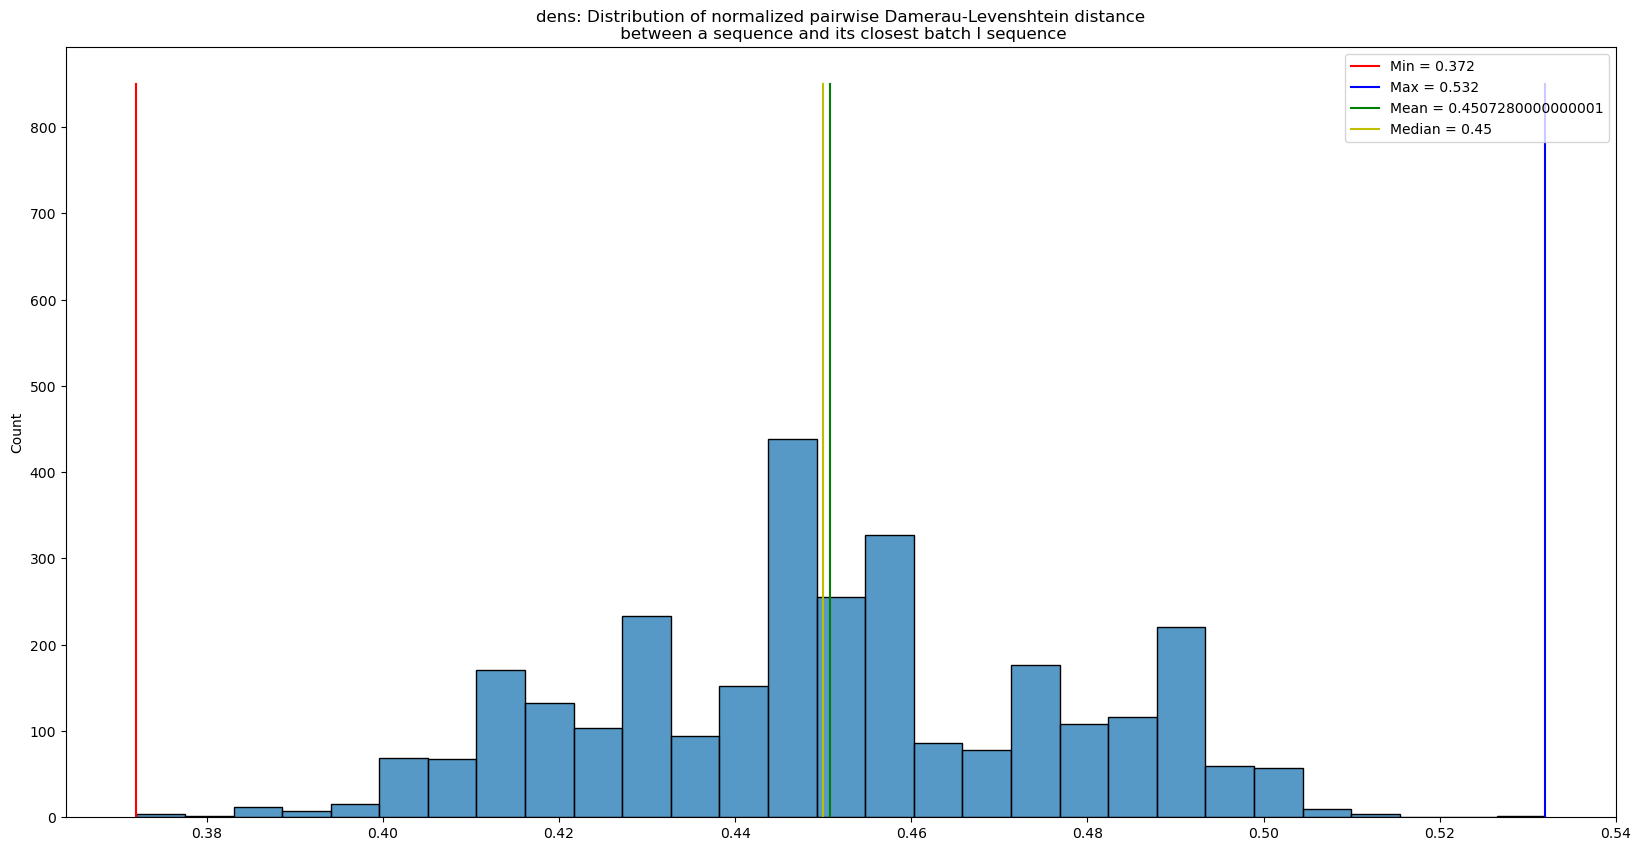

(29206,)


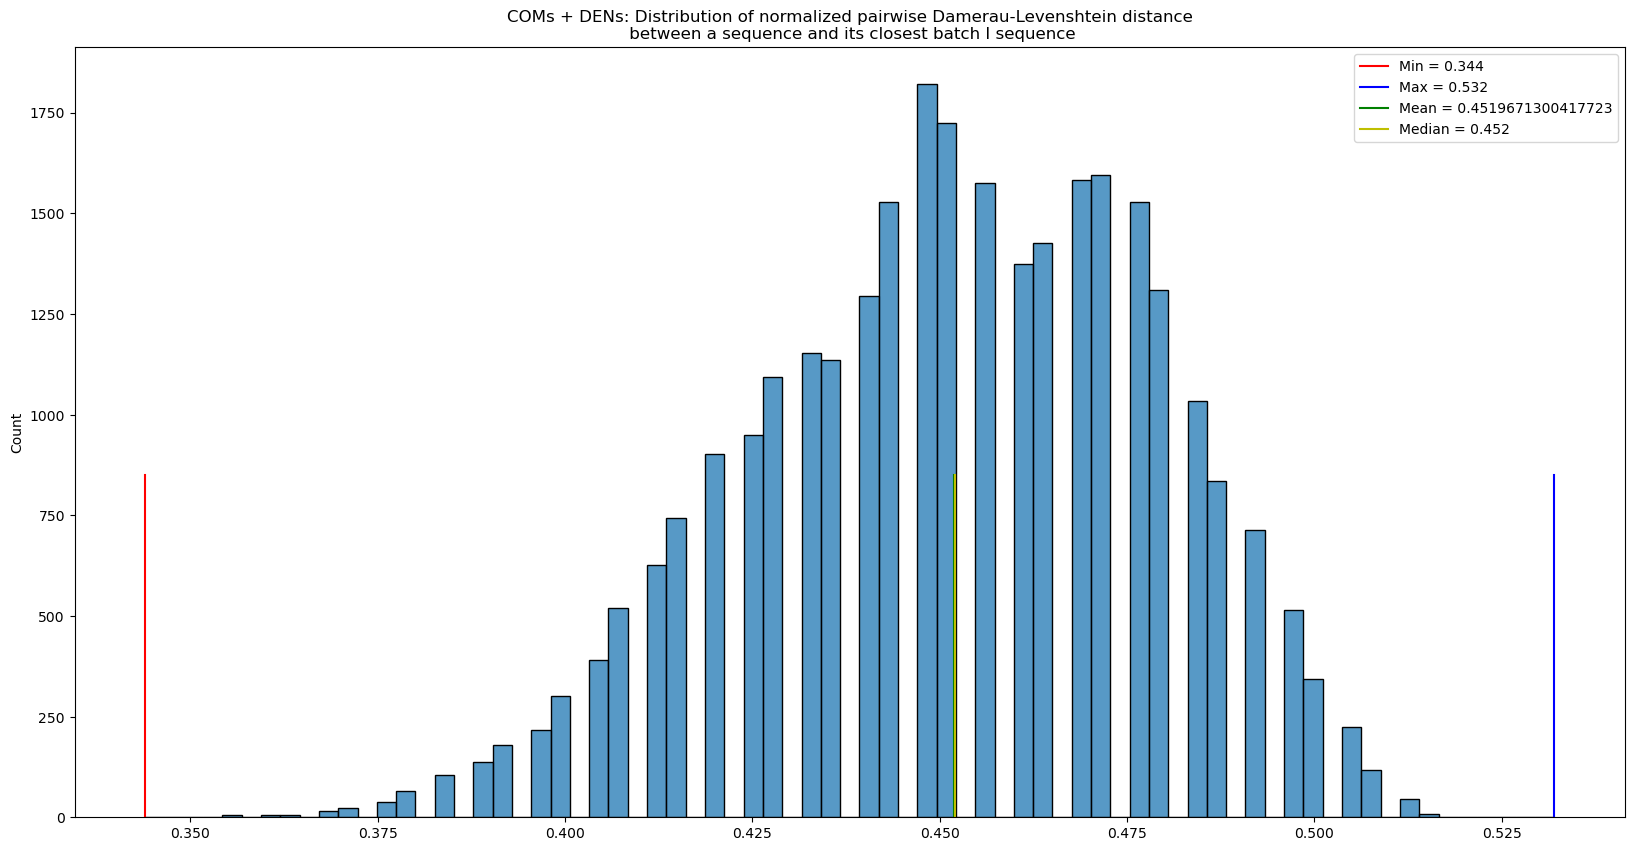

In [12]:
# get distribution of min pairwise distances for each method to batch I sequences
for method in methods + ["COMs + DENs"]:
    if method == "COMs + DENs":
        seq_inds = all_sources != "Dataset"
    else:
        seq_inds = all_sources == method
    dataset_seq_inds = all_sources == "Dataset"
    method_pairwise_dist_matrix = pairwise_distances[seq_inds][:, dataset_seq_inds]
    min_dist_to_another_seq = method_pairwise_dist_matrix.min(axis=1) / 250
    print(min_dist_to_another_seq.shape)
    
#     triu_inds = np.triu_indices_from(method_pairwise_dist_matrix, k=-1)
#     triu_mat = method_pairwise_dist_matrix[triu_inds]
    
    plt.figure(figsize=(20, 10))
    sns.histplot(min_dist_to_another_seq)
    plt.plot([min_dist_to_another_seq.min() for i in range(10)], np.linspace(0, 850, 10), "r-", label=f"Min = {min_dist_to_another_seq.min()}")
    plt.plot([min_dist_to_another_seq.max() for i in range(10)], np.linspace(0, 850, 10), "b-", label=f"Max = {min_dist_to_another_seq.max()}")
    plt.plot([min_dist_to_another_seq.mean() for i in range(10)], np.linspace(0, 850, 10), "g-", label=f"Mean = {min_dist_to_another_seq.mean()}")
    plt.plot([np.median(min_dist_to_another_seq) for i in range(10)], np.linspace(0, 850, 10), "y-", label=f"Median = {np.median(min_dist_to_another_seq)}")
    plt.title(f"{method}: Distribution of normalized pairwise Damerau-Levenshtein distance\n between a sequence and its closest batch I sequence")
    plt.legend()
    plt.show()